# AutoML Image Classification: Added Noise (Digits)

In [ ]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

![](imgs/gaussian_noise.png)

In [ ]:
import random as rn
from abc import ABC, abstractmethod

import autokeras as ak
import h2o
import matplotlib.pyplot as plt
import numpy as np
from h2o.automl import H2OAutoML
from keras.datasets import fashion_mnist
from numpy.random import RandomState
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier

from dpemu import runner
from dpemu.filters.common import GaussianNoise, Clip
from dpemu.filters.image import RotationPIL
from dpemu.nodes import Array
from dpemu.nodes.series import Series
from dpemu.plotting_utils import visualize_scores, print_results_by_model
from dpemu.utils import generate_tmpdir

In [ ]:
def get_data():
    random_state = RandomState(42)
    x, y = load_digits(return_X_y=True)
    y = y.astype(np.uint8)
    return train_test_split(x, y, test_size=1/7, random_state=random_state)
    # (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    # s = x_train.shape[1]
    # x_train = x_train.reshape((len(x_train), s**2)).astype(np.float64)
    # x_test = x_test.reshape((len(x_test), s**2)).astype(np.float64)    
    # return x_train, x_test, y_train, y_test

In [ ]:
def get_err_root_node():
    err_img_node = Array(reshape=(8, 8))
    # err_img_node = Array(reshape=(28, 28))

    # err_root_node = Series(err_img_node)
    # err_img_node.addfilter(RotationPIL("max_angle"))
    # return err_root_node
    err_root_node = Series(err_img_node)
    err_img_node.addfilter(GaussianNoise("mean", "std"))
    err_img_node.addfilter(Clip("min_val", "max_val"))
    return err_root_node

In [ ]:
def get_err_params_list(data):
    # angle_steps = np.linspace(0, 90, num=6)
    # err_params_list = [{"max_angle": a} for a in angle_steps]
    # return err_params_list
    min_val = np.amin(data)
    max_val = np.amax(data)
    std_steps = np.round(np.linspace(0, max_val, num=6), 3)
    err_params_list = [{"mean": 0, "std": std, "min_val": min_val, "max_val": max_val} for std in std_steps]
    return err_params_list

In [ ]:
class Preprocessor:

    def run(self, train_data, test_data, params):
        return np.round(train_data).astype(np.uint8), np.round(test_data).astype(np.uint8), {}

In [ ]:
class AbstractModel(ABC):

    def __init__(self):
        self.time_limit_mins = 60*3
        self.seed = 42
        self.random_state = RandomState(self.seed)
        np.random.seed(self.seed)

    @abstractmethod
    def get_fitted_model(self, train_data, train_labels, params):
        pass

    @abstractmethod
    def get_accuracy(self, data, labels, fitted_model, params):
        pass

    @abstractmethod
    def get_best_pipeline(self, fitted_model):
        pass

    def run(self, train_data, test_data, params):
        train_labels = params["train_labels"]
        test_labels = params["test_labels"]

        fitted_model = self.get_fitted_model(train_data, train_labels, params)

        results = {
            "test_acc": self.get_accuracy(test_data, test_labels, fitted_model, params),
            "train_acc": self.get_accuracy(train_data, train_labels, fitted_model, params),
            "best_pipeline": self.get_best_pipeline(fitted_model),
        }
        print(type(fitted_model))
        print(results["test_acc"])
        return results

class TPOTClassifierModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, train_data, train_labels, params):
        return TPOTClassifier(
            max_time_mins=self.time_limit_mins,
            max_eval_time_mins=self.time_limit_mins,
            n_jobs=-1,
            random_state=self.seed,
            verbosity=1,
        ).fit(train_data, train_labels)

    def get_accuracy(self, data, labels, fitted_model, params):
        return round(fitted_model.score(data, labels), 3)

    def get_best_pipeline(self, fitted_model):
        return [step[1] for step in fitted_model.fitted_pipeline_.steps]

class H2OAutoMLModel(AbstractModel):

    def __init__(self):
        super().__init__()
        h2o.init(name=f"#{rn.SystemRandom().randint(1, 2**30)}", nthreads=16)
        h2o.no_progress()

    def get_fitted_model(self, train_data, train_labels, params):
        train_data = h2o.H2OFrame(np.concatenate((train_data, train_labels.reshape(-1, 1)), axis=1))
        x = np.array(train_data.columns)[:-1].tolist()
        y = np.array(train_data.columns)[-1].tolist()
        train_data[y] = train_data[y].asfactor()
        aml = H2OAutoML(max_runtime_secs=60*self.time_limit_mins, seed=self.seed)
        aml.train(x=x, y=y, training_frame=train_data)
        return aml

    def get_accuracy(self, data, labels, fitted_model, params):
        data = h2o.H2OFrame(np.concatenate((data, labels.reshape(-1, 1)), axis=1))
        y = np.array(data.columns)[-1].tolist()
        data[y] = data[y].asfactor()
        pred = fitted_model.predict(data).as_data_frame(header=False)["predict"].values.astype(int)
        return np.round(np.mean(pred == labels), 3)

    def get_best_pipeline(self, fitted_model):
        leader_params = fitted_model.leader.get_params()
        best_pipeline = [leader_params["model_id"]["actual_value"]["name"]]
        if "base_models" in leader_params:
            for base_model in leader_params["base_models"]["actual_value"]:
                best_pipeline.append(base_model["name"])
        h2o.cluster().shutdown()
        return best_pipeline

class AutoKerasModel(AbstractModel):

    def __init__(self):
        super().__init__()
        import tensorflow as tf
        tf.set_random_seed(self.seed)
        import torch
        torch.multiprocessing.set_sharing_strategy("file_system")
        torch.manual_seed(self.seed)

    def get_fitted_model(self, x_train, y_train, params):
        s = np.sqrt(x_train.shape[1]).astype(int)
        x_train = x_train.reshape((len(x_train), s, s, 1))
        clf = ak.ImageClassifier(augment=False, path=generate_tmpdir(), verbose=False)
        clf.fit(x_train, y_train, time_limit=60*self.time_limit_mins)
        return clf

    def get_accuracy(self, x, y, clf, params):
        s = np.sqrt(x.shape[1]).astype(int)
        x = x.reshape((len(x), s, s, 1))
        y_pred = clf.predict(x)
        return np.round(accuracy_score(y_true=y, y_pred=y_pred), 3)

    def get_best_pipeline(self, clf):
        return [m for i, m in enumerate(clf.cnn.best_model.produce_model().modules()) if i > 0]

In [ ]:
def get_model_params_dict_list(train_labels, test_labels):
    model_params_base = {"train_labels": train_labels, "test_labels": test_labels}
    return [
        {
            "model": AutoKerasModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": AutoKerasModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
        {
            "model": TPOTClassifierModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": TPOTClassifierModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
        {
            "model": H2OAutoMLModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": H2OAutoMLModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
    ]

In [8]:
def visualize(df):
    visualize_scores(
        df,
        score_names=["test_acc", "train_acc"],
        is_higher_score_better=[True, True],
        # err_param_name="max_angle",
        err_param_name="std",
        title="Classification scores with added error"
    )
    plt.show()

In [9]:
train_data, test_data, train_labels, test_labels = get_data()

df = runner.run(
    train_data=train_data,
    test_data=test_data,
    preproc=Preprocessor,
    preproc_params=None,
    err_root_node=get_err_root_node(),
    # err_params_list=get_err_params_list(),
    err_params_list=get_err_params_list(train_data),
    model_params_dict_list=get_model_params_dict_list(train_labels, test_labels),
    n_processes=1
)

  0%|          | 0/6 [00:00<?, ?it/s]

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_232"; OpenJDK Runtime Environment (build 1.8.0_232-b09); OpenJDK 64-Bit Server VM (build 25.232-b09, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpaooufpee

  JVM stdout: /wrk/users/thalvari/tmpaooufpee/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpaooufpee/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,23 days
H2O cluster name:,#885103660
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,56
H2O cluster allowed cores:,56
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_af7f closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.984

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_232"; OpenJDK Runtime Environment (build 1.8.0_232-b09); OpenJDK 64-Bit Server VM (build 25.232-b09, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpdyrr0kd7

  JVM stdout: /wrk/users/thalvari/tmpdyrr0kd7/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpdyrr0kd7/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54323

Connecting to H2O server at http://127.0.0.1:54323 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,23 days
H2O cluster name:,#571226571
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,56
H2O cluster allowed cores:,56
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_bbef closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.977

126.6438813 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(input_matrix, n_neighbors=3, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.981

125.7646514 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(input_matrix, n_neighbors=3, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.981

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.988

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.992

 17%|█▋        | 1/6 [11:45:50<58:49:12, 42350.49s/it]

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_232"; OpenJDK Runtime Environment (build 1.8.0_232-b09); OpenJDK 64-Bit Server VM (build 25.232-b09, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpqy7b2aq4

  JVM stdout: /wrk/users/thalvari/tmpqy7b2aq4/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpqy7b2aq4/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,23 days
H2O cluster name:,#213263217
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,56
H2O cluster allowed cores:,56
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_9bc0 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.946

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_232"; OpenJDK Runtime Environment (build 1.8.0_232-b09); OpenJDK 64-Bit Server VM (build 25.232-b09, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp1ip21gw2

  JVM stdout: /wrk/users/thalvari/tmp1ip21gw2/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp1ip21gw2/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54323

Connecting to H2O server at http://127.0.0.1:54323 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,23 days
H2O cluster name:,#135954157
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,56
H2O cluster allowed cores:,56
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_b25f closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.833

125.4257757 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(BernoulliNB(ExtraTreesClassifier(BernoulliNB(VarianceThreshold(ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.35000000000000003, min_samples_leaf=9, min_samples_split=20, n_estimators=100), threshold=0.0005), alpha=0.01, fit_prior=True), bootstrap=False, criterion=entropy, max_features=0.35000000000000003, min_samples_leaf=9, min_samples_split=20, n_estimators=100), alpha=0.1, fit_prior=True), n_neighbors=4, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.957

127.16222553333334 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(input_matrix, n_neighbors=3, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.965

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.911

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.934

Checking whether there is an H2O instance running at http://localhost:54321 

.

 33%|███▎      | 2/6 [23:45:43<47:20:12, 42603.11s/it]

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_232"; OpenJDK Runtime Environment (build 1.8.0_232-b09); OpenJDK 64-Bit Server VM (build 25.232-b09, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp7xo906_9

  JVM stdout: /wrk/users/thalvari/tmp7xo906_9/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp7xo906_9/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,24 days
H2O cluster name:,#161851648
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,56
H2O cluster allowed cores:,56
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_ae6b closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.817

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_232"; OpenJDK Runtime Environment (build 1.8.0_232-b09); OpenJDK 64-Bit Server VM (build 25.232-b09, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpxl5fbzv_

  JVM stdout: /wrk/users/thalvari/tmpxl5fbzv_/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpxl5fbzv_/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,24 days
H2O cluster name:,#83793641
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,56
H2O cluster allowed cores:,56
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_8567 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.405

123.52615578333332 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(ZeroCount(SelectFwe(XGBClassifier(input_matrix, learning_rate=0.5, max_depth=8, min_child_weight=4, n_estimators=100, nthread=1, subsample=0.5), alpha=0.024)), n_neighbors=48, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.802

125.70109013333334 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(input_matrix, n_neighbors=3, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.903

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.782

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.689

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 50%|█████     | 3/6 [35:16:11<35:12:32, 42250.73s/it]

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_232"; OpenJDK Runtime Environment (build 1.8.0_232-b09); OpenJDK 64-Bit Server VM (build 25.232-b09, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpzd6bmixw

  JVM stdout: /wrk/users/thalvari/tmpzd6bmixw/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpzd6bmixw/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,24 days
H2O cluster name:,#68785326
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,56
H2O cluster allowed cores:,56
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_8386 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.658

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_232"; OpenJDK Runtime Environment (build 1.8.0_232-b09); OpenJDK 64-Bit Server VM (build 25.232-b09, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpd9485x85

  JVM stdout: /wrk/users/thalvari/tmpd9485x85/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpd9485x85/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,24 days
H2O cluster name:,#1027800925
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,56
H2O cluster allowed cores:,56
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_b5eb closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.389

121.41815088333333 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(SelectFwe(ExtraTreesClassifier(MultinomialNB(input_matrix, alpha=0.1, fit_prior=True), bootstrap=True, criterion=gini, max_features=1.0, min_samples_leaf=15, min_samples_split=10, n_estimators=100), alpha=0.009000000000000001), n_neighbors=99, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.689

127.96665841666666 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(input_matrix, n_neighbors=3, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.7

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.502

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.482

 67%|██████▋   | 4/6 [46:40:43<23:16:34, 41897.01s/it]

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_232"; OpenJDK Runtime Environment (build 1.8.0_232-b09); OpenJDK 64-Bit Server VM (build 25.232-b09, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp1lm44uwv

  JVM stdout: /wrk/users/thalvari/tmp1lm44uwv/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp1lm44uwv/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,25 days
H2O cluster name:,#1064440860
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,56
H2O cluster allowed cores:,56
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_9831 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.459

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_232"; OpenJDK Runtime Environment (build 1.8.0_232-b09); OpenJDK 64-Bit Server VM (build 25.232-b09, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpqrl9z008

  JVM stdout: /wrk/users/thalvari/tmpqrl9z008/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpqrl9z008/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,25 days
H2O cluster name:,#1012520594
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,56
H2O cluster allowed cores:,56
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_b3c0 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.261

122.19072471666667 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

MultinomialNB(SelectFwe(MaxAbsScaler(CombineDFs(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), input_matrix)), alpha=0.015), alpha=1.0, fit_prior=False)

/wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


/wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


<class 'tpot.tpot.TPOTClassifier'>

0.525

125.70619688333333 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(input_matrix, n_neighbors=3, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.514

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.327

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.335

 83%|████████▎ | 5/6 [58:01:08<11:32:55, 41575.41s/it]

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_232"; OpenJDK Runtime Environment (build 1.8.0_232-b09); OpenJDK 64-Bit Server VM (build 25.232-b09, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpp0d9lmdv

  JVM stdout: /wrk/users/thalvari/tmpp0d9lmdv/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpp0d9lmdv/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,25 days
H2O cluster name:,#749292829
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,56
H2O cluster allowed cores:,56
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_bba3 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.319

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_232"; OpenJDK Runtime Environment (build 1.8.0_232-b09); OpenJDK 64-Bit Server VM (build 25.232-b09, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmppzy0ebdh

  JVM stdout: /wrk/users/thalvari/tmppzy0ebdh/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmppzy0ebdh/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54323

Connecting to H2O server at http://127.0.0.1:54323 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,25 days
H2O cluster name:,#545772446
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,56
H2O cluster allowed cores:,56
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_8997 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.156

123.02586975 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

MultinomialNB(ZeroCount(GaussianNB(RFE(input_matrix, criterion=entropy, max_features=0.3, n_estimators=100, step=0.2))), alpha=0.001, fit_prior=False)

<class 'tpot.tpot.TPOTClassifier'>

0.346

127.90489538333333 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(input_matrix, n_neighbors=3, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.342

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.233

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.257

100%|██████████| 6/6 [68:33:22<00:00, 40482.92s/it]   

100%|██████████| 6/6 [68:33:22<00:00, 41133.67s/it]

'AutoKeras #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.988,0.999,0.137,0.001,7236.34
3.2,0.911,0.994,0.105,0.001,7204.45
6.4,0.782,0.968,0.114,0.001,7215.46
9.6,0.502,0.949,0.098,0.001,7236.22
12.8,0.327,0.914,0.162,0.001,7212.31
16,0.233,0.787,0.162,0.001,7215.8


std,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21,pipe_22,pipe_23,pipe_24,pipe_25,pipe_26,pipe_27,pipe_28,pipe_29,pipe_30,pipe_31,pipe_32,pipe_33,pipe_34,pipe_35,pipe_36,pipe_37,pipe_38,pipe_39,pipe_40,pipe_41,pipe_42,pipe_43,pipe_44,pipe_45,pipe_46,pipe_47,pipe_48,pipe_49,pipe_50,pipe_51,pipe_52,pipe_53,pipe_54,pipe_55,pipe_56,pipe_57,pipe_58,pipe_59,pipe_60,pipe_61,pipe_62,pipe_63,pipe_64,pipe_65,pipe_66,pipe_67,pipe_68,pipe_69,pipe_70,pipe_71,pipe_72,pipe_73,pipe_74,pipe_75,pipe_76,pipe_77,pipe_78,pipe_79
0,"Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),GlobalAvgPool2d(),"Linear(in_features=512, out_features=10, bias=True)","Conv2d(512, 512, kernel_s

'AutoKerasClean #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.992,0.999,0.137,0.001,7213.51
3.2,0.934,0.999,0.105,0.001,7208.44
6.4,0.689,0.999,0.114,0.001,7212.11
9.6,0.482,0.999,0.098,0.001,7219.21
12.8,0.335,0.999,0.162,0.001,7213.43
16,0.257,0.999,0.162,0.001,7211.06


std,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21,pipe_22,pipe_23,pipe_24,pipe_25,pipe_26,pipe_27,pipe_28,pipe_29,pipe_30,pipe_31,pipe_32,pipe_33,pipe_34,pipe_35,pipe_36,pipe_37,pipe_38,pipe_39,pipe_40,pipe_41,pipe_42,pipe_43,pipe_44,pipe_45,pipe_46,pipe_47,pipe_48,pipe_49,pipe_50,pipe_51,pipe_52,pipe_53,pipe_54,pipe_55,pipe_56,pipe_57,pipe_58,pipe_59,pipe_60,pipe_61,pipe_62,pipe_63,pipe_64,pipe_65,pipe_66,pipe_67,pipe_68,pipe_69,pipe_70,pipe_71,pipe_72,pipe_73,pipe_74,pipe_75,pipe_76,pipe_77,pipe_78,pipe_79,pipe_80,pipe_81,pipe_82
0,"Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),GlobalAvgPool2d(),"Linear(in_features=512, out_features=10, bias=True)",Re

'H2OAutoML #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.984,1,0.137,0.001,6377.28
3.2,0.946,1,0.105,0.001,7244.32
6.4,0.817,1,0.114,0.001,5657.23
9.6,0.658,0.999,0.098,0.001,5276.99
12.8,0.459,1,0.162,0.001,5144.97
16,0.319,0.992,0.162,0.001,2057.88


std,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21,pipe_22,pipe_23,pipe_24,pipe_25,pipe_26,pipe_27,pipe_28,pipe_29,pipe_30,pipe_31,pipe_32,pipe_33,pipe_34,pipe_35,pipe_36,pipe_37,pipe_38,pipe_39,pipe_40,pipe_41,pipe_42,pipe_43,pipe_44,pipe_45,pipe_46,pipe_47,pipe_48,pipe_49,pipe_50,pipe_51,pipe_52,pipe_53,pipe_54,pipe_55,pipe_56,pipe_57,pipe_58,pipe_59,pipe_60,pipe_61,pipe_62,pipe_63,pipe_64,pipe_65,pipe_66,pipe_67,pipe_68,pipe_69,pipe_70,pipe_71,pipe_72,pipe_73,pipe_74,pipe_75,pipe_76,pipe_77,pipe_78,pipe_79,pipe_80,pipe_81,pipe_82,pipe_83,pipe_84,pipe_85,pipe_86,pipe_87,pipe_88,pipe_89,pipe_90,pipe_91,pipe_92,pipe_93,pipe_94,pipe_95,pipe_96,pipe_97,pipe_98,pipe_99,pipe_100,pipe_101,pipe_102,pipe_103,pipe_104,pipe_105,pipe_106,pipe_107,pipe_108,pipe_109,pipe_110,pipe_111,pipe_112,pipe_113,pipe_114,pipe_115,pipe_116,pipe_117,pipe_118,pipe_119,pipe_120,pipe_121,pipe_122,pipe_123,pipe_124,pipe_125,pipe_126,pipe_127,pipe_128,pipe_129,pipe_130,pipe_131,pipe_132,pipe_133,pipe_134,pipe_135,pipe_136,pipe_137,pipe_138,pipe_139,pipe_140,pipe_141,pipe_142,pipe_143,pipe_144,pipe_145,pipe_146,pipe_147,pipe_148,pipe_149,pipe_150,pipe_151,pipe_152,pipe_153,pipe_154,pipe_155,pipe_156,pipe_157,pipe_158,pipe_159,pipe_160,pipe_161,pipe_162,pipe_163,pipe_164,pipe_165,pipe_166,pipe_167,pipe_168,pipe_169,pipe_170,pipe_171,pipe_172,pipe_173,pipe_174,pipe_175,pipe_176,pipe_177,pipe_178,pipe_179,pipe_180,pipe_181,pipe_182,pipe_183,pipe_184,pipe_185,pipe_186,pipe_187,pipe_188,pipe_189,pipe_190,pipe_191,pipe_192,pipe_193,pipe_194,pipe_195,pipe_196,pipe_197,pipe_198,pipe_199,pipe_200,pipe_201,pipe_202,pipe_203,pipe_204,pipe_205,pipe_206,pipe_207,pipe_208,pipe_209,pipe_210,pipe_211,pipe_212,pipe_213,pipe_214,pipe_215,pipe_216,pipe_217,pipe_218,pipe_219,pipe_220,pipe_221,pipe_222,pipe_223
0,DeepLearning_grid_1_AutoML_20191110_083707_model_20,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3.2,StackedEnsemble_BestOfFamily_AutoML_20191110_202257,DeepLearning_grid_1_AutoML_20191110_202257_model_49,GBM_grid_1_AutoML_20191110_202257_model_31,XGBoost_grid_1_AutoML_20191110_202257_model_129,DRF_1_AutoML_20191110_202257,XRT_1_AutoML_20191110_202257,GLM_grid_1_AutoML_20191110_202257_model_1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,n

'H2OAutoMLClean #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.977,1,0.137,0.001,6375.54
3.2,0.833,1,0.105,0.001,6372.98
6.4,0.405,1,0.114,0.001,6380.56
9.6,0.389,1,0.098,0.001,6372.2
12.8,0.261,1,0.162,0.001,6377.72
16,0.156,1,0.162,0.001,6381.1


std,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6
0,StackedEnsemble_BestOfFamily_AutoML_20191110_102324,DeepLearning_grid_1_AutoML_20191110_102324_model_49,GBM_grid_1_AutoML_20191110_102324_model_145,XGBoost_grid_1_AutoML_20191110_102324_model_13,DRF_1_AutoML_20191110_102324,XRT_1_AutoML_20191110_102324,GLM_grid_1_AutoML_20191110_102324_model_1
3.2,StackedEnsemble_BestOfFamily_AutoML_20191110_222342,DeepLearning_grid_1_AutoML_20191110_222342_model_4,GBM_grid_1_AutoML_20191110_222342_model_145,XGBoost_grid_1_AutoML_20191110_222342_model_13,DRF_1_AutoML_20191110_222342,XRT_1_AutoML_20191110_222342,GLM_grid_1_AutoML_20191110_222342_model_1
6.4,StackedEnsemble_BestOfFamily_AutoML_20191111_095707,DeepLearning_grid_1_AutoML_20191111_095707_model_15,GBM_grid_1_AutoML_20191111_095707_model_145,XGBoost_grid_1_AutoML_20191111_095707_model_13,DRF_1_AutoML_20191111_095707,XRT_1_AutoML_20191111_095707,GLM_grid_1_AutoML_20191111_095707_model_1
9.6,StackedEnsemble_BestOfFamily_AutoML_20191111_212114,DeepLearning_grid_1_AutoML_20191111_212114_model_24,GBM_grid_1_AutoML_20191111_212114_model_145,XGBoost_grid_1_AutoML_20191111_212114_model_13,DRF_1_AutoML_20191111_212114,XRT_1_AutoML_20191111_212114,GLM_grid_1_AutoML_20191111_212114_model_1
12.8,StackedEnsemble_BestOfFamily_AutoML_20191112_084336,DeepLearning_grid_1_AutoML_20191112_084336_model_48,GBM_grid_1_AutoML_20191112_084336_model_145,XGBoost_grid_1_AutoML_20191112_084336_model_13,DRF_1_AutoML_20191112_084336,XRT_1_AutoML_20191112_084336,GLM_grid_1_AutoML_20191112_084336_model_1
16,StackedEnsemble_BestOfFamily_AutoML_20191112_191233,DeepLearning_grid_1_AutoML_20191112_191233_model_50,GBM_grid_1_AutoML_20191112_191233_model_145,XGBoost_grid_1_AutoML_20191112_191233_model_13,DRF_1_AutoML_20191112_191233,XRT_1_AutoML_20191112_191233,GLM_grid_1_AutoML_20191112_191233_model_1


'TPOTClassifier #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.981,1,0.137,0.001,7600.47
3.2,0.957,1,0.105,0.001,7531.19
6.4,0.802,1,0.114,0.001,7418.55
9.6,0.689,1,0.098,0.001,7288.33
12.8,0.525,0.536,0.162,0.001,7332.62
16,0.346,0.432,0.162,0.001,7391.72


std,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5
0,"KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=3, p=2, weights='distance')",nan,nan,nan,nan,nan
3.2,"StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy', max_depth=None, max_features=0.35000000000000003, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=9, min_samples_split=20, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False))",VarianceThreshold(threshold=0.0005),"StackingEstimator(estimator=BernoulliNB(alpha=0.01, binarize=0.0, class_prior=None, fit_prior=True))","StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy', max_depth=None, max_features=0.35000000000000003, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=9, min_samples_split=20, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False))","StackingEstimator(estimator=BernoulliNB(alpha=0.1, binarize=0.0, class_prior=None, fit_prior=True))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=4, p=2, weights='distance')"
6.4,"StackingEstimator(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.5, max_delta_step=0, max_depth=8, min_child_weight=4, missing=nan, n_estimators=100, n_jobs=1, nthread=1, objective='multi:softprob', random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=None, subsample=0.5, verbosity=1))","SelectFwe(alpha=0.024, score_func=)",ZeroCount(),"KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=48, p=2, weights='distance')",nan,nan
9.6,"StackingEstimator(estimator=MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True))","StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='gini', max_depth=None, max_features=1.0, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=15, min_samples_split=10, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False))","SelectFwe(alpha=0.009000000000000001, score_func=)","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=99, p=2, weights='distance')",nan,nan
12.8,"FeatureUnion(n_jobs=None, transformer_list=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False, order='C')), ('functiontransformer', FunctionTransformer(accept_sparse=False, check_inverse=True, func=, inv_kw_args=None, inverse_func=None, kw_args=None, pass_y='deprecated', validate=None))], transformer_weights=None, verbose=False)",MaxAbsScaler(copy=True),"SelectFwe(alpha=0.015, score_func=)","MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)",nan,nan
16,"RFE(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy', max_depth=None, max_features=0.3, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False), n_features_to_select=None, step=0.2, verbose=0)","StackingEstimator(estimator=GaussianNB(priors=None, var_smoothing=1e-09))",ZeroCount(),"MultinomialNB(alpha=0.001, class_prior=None, fit_prior=False)",nan,nan


'TPOTClassifierClean #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.981,1,0.137,0.001,7546.83
3.2,0.965,1,0.105,0.001,7630.69
6.4,0.903,1,0.114,0.001,7543.17
9.6,0.7,1,0.098,0.001,7679.14
12.8,0.514,1,0.162,0.001,7543.52
16,0.342,1,0.162,0.001,7675.46


std,pipe_0
0,"KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=3, p=2, weights='distance')"
3.2,"KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=3, p=2, weights='distance')"
6.4,"KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=3, p=2, weights='distance')"
9.6,"KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=3, p=2, weights='distance')"
12.8,"KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=3, p=2, weights='distance')"
16,"KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=3, p=2, weights='distance')"


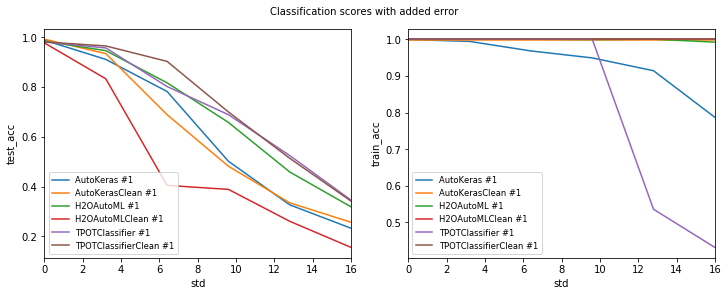

In [10]:
print_results_by_model(df,
    # ["train_labels", "test_labels"],
    ["mean", "min_val", "max_val", "train_labels", "test_labels"], 
    # err_param_name="max_angle",
    err_param_name="std",
    pipeline_name="best_pipeline"
)
visualize(df)